In [1]:
import networkx as nx
import sympy
from sympy.ntheory import primefactors

import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display

import pulp 
from itertools import chain, combinations

# Really interesting puzzle and plenty of info online
# mostly as it was used as an NRICH puzzle
# https://nrich.maths.org/factorsandmultiples
#
# The longest path for each integer up to 200 is https://oeis.org/A337125   
# There are some good links on that page 
# However the solution below is based on dividing up the graph and 
# working out how to join up the subpaths
#
# On the OEIS page there is a LP solution which I have implemented below
# it get slow quickly so I wonder how they managed to get to 200.

In [2]:
url='https://www.janestreet.com/puzzles/chain-reaction-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:13]))))

### July 2014 : Puzzle

Write down a chain of integers between 1 and 100, with no repetition, such that
if x and y are consecutive numbers in the chain, then x evenly divides y or y
evenly divides x. Here is an example of such a chain, with length 12:
37, 74, 2, 8, 4, 16, 48, 6, 3, 9, 27, 81
What is the longest chain you can find?

In [3]:
primes = list(sympy.primerange(0, 100))

# Question is to find the longest simple path on the divisor graph of the integers up to 100

# loop through all paths in numbs between a and b and find the longest
def longest_simple_path(numbs,a,b ):
    g = nx.Graph()

    numbs.sort()      
    [g.add_edge(numbs[i],numbs[j]) for i in range(len(numbs)) for j in range(i+1,len(numbs))if numbs[j] % numbs[i] == 0]
    
    return max(nx.all_simple_paths(g,a,b), key=len)
           
# add in the longest sequence around number n entering at a and leaving at b
def bring_in(n,a,b,sequence):
    raw = [i*n for i in range(1,50) if i*n <101 and i*n in sequence]
    series = longest_simple_path(raw,n*a,n*b)
    print("Adding {} uses {} of the {} available. Start: {} End: {}. Miss {}".format(n,len(series),len(raw),series[0],series[-1],[i for i in raw if i not in series]))
    return series

# final check. Make sure a/b or b/a works and output the omitted numbers.
def left(x,give_up):
    sequence = [*range(1,101)]
    sequence = list(set(sequence)-set(give_up))
    sequence = list(set(sequence)-set(x))
    for i in range(1,len(x)):
        if (x[i] % x[i-1] !=0) & (x[i-1] % x[i] !=0):
            print("FAIL",x[i], x[i-1])
    return sequence,[primefactors(i) for i in sequence]

In [4]:
# Based largely on the logic here https://theorie.ikp.physik.tu-darmstadt.de/qcd/numchain.pdf
#
# Both the solution in this paper and the Jane St solution have similar logic but make different choices on ordering and links
# This was also a puzzle on 538 and there are 2 solutions given with different choices (see below)
# Finding the longest path on the full graph takes too long but if you break it down into areas around the primes it becomes simpler

start = time.time()

# start with the list of integers
sequence = [*range(1,101)]

# give up on primes 37+ and their multiples
give_up = [i*j for i in sympy.primerange(32, 100) for j in [1,2] if i*j <101]
sequence = list(set(sequence)-set(give_up))

print("After removing large primes there are {} left".format(len(sequence)))

# for primes above 13 [17,19,23,29,31] use up 4,3,2,1 to capture as many multiples as possible finishing at 19 or 17 so I can use 5 to link to 13
# Have to miss either 17*3 or 19*3
prime_series =[i*j for i in [1,*sympy.primerange(14,32)] for j in [1,2,3,4] if i*j < 101]
prime_ordered = longest_simple_path(prime_series,17*3,19)
sequence = list(set(sequence)-set(prime_ordered))

print("The are {} in the prime sequence ".format(len(prime_series)))
print("The longest sequence is {} long. Miss {}".format(len(prime_ordered),[i for i in prime_series if i not in prime_ordered]))

# bring in multiples of 13 using 5 to link to 17/19 and use 6 at the end to maximise the length
link_1 = [19*5,5]
sequence = list(set(sequence)-set(link_1))
series_13 = bring_in(13,5,6,sequence)
sequence = list(set(sequence)-set(series_13))

#link between 6 and 9 
link_2=[6, 36, 18, 54, 27, 81, 9]
sequence = list(set(sequence)-set(link_2))

# bring in multiples of 7 using 9/10 ... starting or ending with 6 can't get to lenght 12 (see below)
series_7 = bring_in(7,9,10,sequence)
sequence = list(set(sequence)-set(series_7))

# bring in multiples of 11 by using 8 at the start (have to lose either 55 or 77)
series_11 = bring_in(11,8,5,sequence)  # can have choose either 5 or 7 at the end
sequence = list(set(sequence)-set(series_11))

# find the longest path between 10 and 8 in the rest
rest= longest_simple_path(sequence,10,8)
print("We can then use {} of the remaining {}. Missing {}".format(len(rest),len(sequence),[i for i in sequence if i not in rest]))
sequence = list(set(sequence)-set(rest))


print("\nFinal Sequence")
print("~~~~~~~~~~~~~~")
final_sequence = prime_ordered+link_1+series_13+link_2+series_7+rest+series_11
print(final_sequence)
print("\nLength is {}".format(len(set(final_sequence))))
print("Took {:.2f} seconds".format(time.time()-start))
print("\nNumbers left")
print(left(final_sequence,give_up))

print("\nELEMENTS")
print(prime_ordered)
print(link_1)
print(series_13)
print(link_2)
print(series_7)
print(rest)
print(series_11)


After removing large primes there are 82 left
The are 22 in the prime sequence 
The longest sequence is 21 long. Miss [57]
Adding 13 uses 5 of the 7 available. Start: 65 End: 78. Miss [39, 91]
Adding 7 uses 12 of the 14 available. Start: 63 End: 70. Miss [77, 91]
Adding 11 uses 8 of the 9 available. Start: 88 End: 55. Miss [77]
We can then use 22 of the remaining 27. Missing [39, 57, 77, 85, 91]

Final Sequence
~~~~~~~~~~~~~~
[51, 17, 34, 68, 1, 87, 29, 58, 2, 62, 31, 93, 3, 69, 23, 46, 92, 4, 76, 38, 19, 95, 5, 65, 13, 52, 26, 78, 6, 36, 18, 54, 27, 81, 9, 63, 21, 42, 84, 28, 56, 14, 98, 49, 7, 35, 70, 10, 20, 100, 50, 25, 75, 15, 45, 90, 30, 60, 12, 72, 24, 48, 96, 32, 64, 16, 80, 40, 8, 88, 44, 22, 66, 33, 99, 11, 55]

Length is 77
Took 0.91 seconds

Numbers left
([39, 77, 85, 57, 91], [[3, 13], [7, 11], [5, 17], [3, 19], [7, 13]])

ELEMENTS
[51, 17, 34, 68, 1, 87, 29, 58, 2, 62, 31, 93, 3, 69, 23, 46, 92, 4, 76, 38, 19]
[95, 5]
[65, 13, 52, 26, 78]
[6, 36, 18, 54, 27, 81, 9]
[63, 2

In [5]:
url='https://www.janestreet.com/puzzles/chain-reaction-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("".join(y[10:11]))))

### July 2014 : Solution

Tough, open-ended puzzle this month! Many came close, but we received 7
submissions with chains of length 77, which is also the longest we could find.
Congratulations to Alexander Chappell, one of the 7, and this month’s randomly
chosen winner of a Jane Street t-shirt! His submission was: 69 23 46 92 4 76 38
19 95 5 85 17 68 34 2 62 31 93 3 87 29 58 1 49 98 14 56 28 84 42 21 63 9 81 27
54 18 72 36 12 6 66 33 99 11 22 44 88 8 24 48 96 32 64 16 80 40 20 60 30 90 45
15 75 25 100 50 10 70 35 7 91 13 39 78 26 52

In [6]:
# the Jane st and paper solutions. Split into the various regions

# paper solution is a variant of the solution above (choose a different prime sequence start and end at 17 not 19)
soln1 = [62, 31, 93, 1, 87, 29, 58, 2, 46, 92, 23, 69, 3, 57, 19, 38, 76, 4, 68, 34, 17,
         85, 
         5, 65, 13, 52, 26, 78,
         6, 36, 18, 54, 27, 81, 
         9, 63, 21, 42, 84, 28, 56, 14, 98, 49,7, 35, 70, 
         10, 40, 80, 20, 100, 50, 25, 75, 15, 45, 90, 30, 60, 12, 72, 24, 48, 16, 96, 32, 64,
         8, 88, 44, 22, 66, 33, 99, 11, 55]

# as above uses 5 in the prime sequence to get both 5*17 and 5*19 but loses 5*13 (and 3*19)
# gives up both 5*11 and 7*11 and uses the 13 sequence at the end to get 3*13 and 7*13
soln2 = [69, 23, 46, 92, 4, 76, 38, 19, 
         95, 
         5, 85, 17, 68, 34,2, 62, 31, 93, 3, 87, 29, 58, 1, 49, 98, 14, 56, 28, 84, 42, 21, 63, 
         9,  81, 27, 54, 18, 72, 36, 12, 
         6, 66, 33, 99, 11, 22, 44, 88,
         8, 24, 48, 96, 32, 64, 16, 80, 40, 20, 60, 30, 90, 45, 15, 75, 25, 100, 50, 
         10, 70, 35, 7, 91, 13, 39, 78, 26, 52]

# 2 from https://fivethirtyeight.com/features/is-this-bathroom-occupied/
# split the prime series at 1 moving the second half to the end giving up 3*19 to get 5*19
soln3 = [62, 31, 93, 3, 69, 23, 46, 92, 4, 76, 38, 19, 
         95, 
         5, 65, 13, 52, 26, 78, 
         6, 48,  96, 32, 64, 16, 80, 
         10, 70, 35, 7, 49, 98, 14, 56, 28, 84, 42, 21, 63, 
         9, 81, 27,54, 18, 36, 72, 24, 12, 60, 30, 90, 45, 15, 75, 25, 50, 100, 20, 40,
         8, 88, 44, 22, 66, 33, 99, 11, 55, 
         1, 87, 29, 58, 2, 68, 34, 17, 85]

# fun solution links the 13 and 7 sequences to get 7*13 losing 5*13
soln4 =[93, 31, 62, 1, 87, 29, 58, 2, 92, 46, 23, 69, 3, 57, 19, 38, 76, 4, 68, 34, 17, 
        85, 
        5, 35, 70, 
        10, 100, 50, 25, 75, 15, 45, 90, 30, 60, 20, 40, 80, 16, 64, 32, 96, 48, 24, 12, 
        6, 78, 26, 52, 13, 91, 7, 49, 98, 14, 56, 28, 84, 42, 21, 63, 
        9, 81, 27, 54, 18, 36, 72, 
        8, 88, 44, 22, 66, 33, 99, 11, 55]

print(left(soln1,give_up))
print(left(soln2,give_up))
print(left(soln3,give_up))
print(left(soln4,give_up))

([39, 77, 51, 91, 95], [[3, 13], [7, 11], [3, 17], [7, 13], [5, 19]])
([65, 77, 51, 55, 57], [[5, 13], [7, 11], [3, 17], [5, 11], [3, 19]])
([39, 77, 51, 57, 91], [[3, 13], [7, 11], [3, 17], [3, 19], [7, 13]])
([65, 39, 77, 51, 95], [[5, 13], [3, 13], [7, 11], [3, 17], [5, 19]])


In [7]:
# function to look at areas round primes and the best way to use low numbers to go in and out of those sub-graphs
def links(n):
    g = nx.Graph()
    numbs = [i*j for i in range(1,100//n+1) for j in [n] if i*j <101 and i*j not in [1,2,3,4]]
    print("There are {} available".format(len(numbs)))        
    [g.add_edge(numbs[i],numbs[j]) for i in range(len(numbs)) for j in range(i+1,len(numbs)) if numbs[j] % numbs[i] == 0]
    
    fig, ax = plt.subplots(figsize=(10,5))
    pos = nx.spring_layout(g, seed=100)  
    options = {
        "font_size": 10,
        "node_size": 300,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 1,
        "width": 1,
        }
    nx.draw_networkx(g, pos, **options)
    plt.show()
    for a in range(5,min(100//n,15)):
        for b in range(a+1,min(100//n+1,10)):
            print("For {}-{} ({}-{}) longest path length is {}".format(
                    a,b,a*n,b*n,len(max(nx.all_simple_paths(g,a*n,b*n),key=len))))

There are 7 available


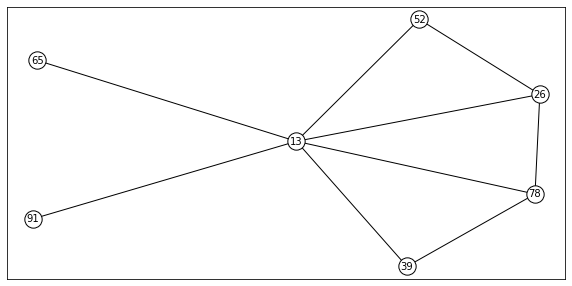

For 5-6 (65-78) longest path length is 5
For 5-7 (65-91) longest path length is 3
For 6-7 (78-91) longest path length is 5


In [8]:
links(13)

There are 9 available


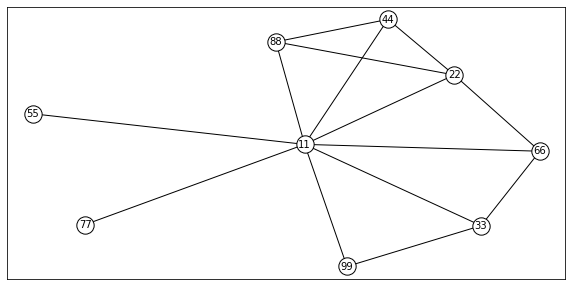

For 5-6 (55-66) longest path length is 6
For 5-7 (55-77) longest path length is 3
For 5-8 (55-88) longest path length is 8
For 5-9 (55-99) longest path length is 8
For 6-7 (66-77) longest path length is 6
For 6-8 (66-88) longest path length is 7
For 6-9 (66-99) longest path length is 7
For 7-8 (77-88) longest path length is 8
For 7-9 (77-99) longest path length is 8
For 8-9 (88-99) longest path length is 7


In [9]:
links(11)

There are 14 available


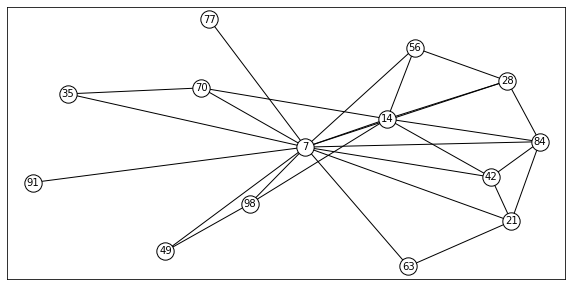

For 5-6 (35-42) longest path length is 11
For 5-7 (35-49) longest path length is 12
For 5-8 (35-56) longest path length is 12
For 5-9 (35-63) longest path length is 12
For 6-7 (42-49) longest path length is 11
For 6-8 (42-56) longest path length is 10
For 6-9 (42-63) longest path length is 10
For 7-8 (49-56) longest path length is 12
For 7-9 (49-63) longest path length is 12
For 8-9 (56-63) longest path length is 10


In [10]:
links(7)

<hr>

### From <https://oeis.org/A337125>

Can be formulated as an optimal subtour problem by introducing a depot node 0 that is adjacent to all other nodes. An integer linear programming formulation is as follows. <br>
* For {i,j} in E, let binary decision variable x_{i,j} indicate whether edge {i,j} is traversed
* For i in N let binary decision variable y_i indicate whether node i is visited. 
* The objective is to maximize $\sum_{i in N \ {0}} y_i. $
<br>The constraints are: 
* $\sum_{{i,j} in E: k in {i,j}} x_{i,j} = 2 y_k$ for all k in N, y_0 = 1, 
* as well as (dynamically generated) generalized subtour elimination constraints $\sum_{i in S, j in S: {i,j} in E} x_{i,j} <= \sum_{i in S \ {k}} y_i$ for all S subset $N \ {0}$ and k in S. 

`Rob Pratt, Dec 28 2020`

Setup took 0.0100 seconds
 
Took 0.0808 seconds
 
[51, 17, 68, 34, 2, 62, 31, 93, 3, 87, 29, 58, 1, 55, 11, 99, 33, 66, 22, 44, 88, 8, 56, 28, 84, 21, 63, 9, 81, 27, 54, 18, 36, 12, 72, 24, 48, 96, 32, 64, 16, 80, 40, 20, 60, 30, 90, 45, 15, 75, 25, 50, 100, 10, 70, 35, 7, 49, 98, 14, 42, 6, 78, 26, 52, 13, 65, 5, 95, 19, 38, 76, 4, 92, 46, 23, 69]

Path Length 77


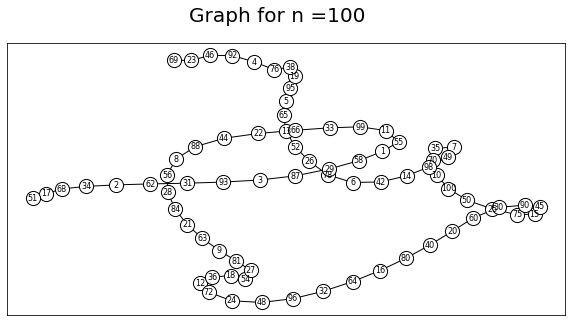

In [51]:
# Looking at every subtour starts to get very slow at n =16.
# For some numbers (50,60) the solution comes out perfectly
# Interestingly the number of linked cells looks about right 
# even with subtours.
# Manually eliminating subtours works well and gets the solution.
# Need to work out a way of identifying and eliminating them



start = time.time()

length = 100

model=pulp.LpProblem('tsp',pulp.LpMaximize)

###############
#  Variables  #
###############
N = pulp.LpVariable.dicts("N",[i for i in range(length+1)],upBound=1,lowBound=0,cat='Binary')
E = pulp.LpVariable.dicts("E",[(i,j) for i in range(1,length) for j in range(i+1,length+1) if j % i==0],upBound=1,lowBound=0,cat='Binary')
for i in range(1,length+1):
    E[(0,i)] = pulp.LpVariable("E_(%s,_%s)" % (0,i),upBound=1,lowBound=0,cat='Binary')

give_up = [i*j for i in sympy.primerange(32, 100) for j in [1,2] if i*j <101]+[3*13,7*11,5*17,3*19,7*13]

model += N[0] == 1   

for i in range(length+1):
     if i in give_up:
        model += N[i] == 0

###################
#    Objective    #
###################
model += pulp.lpSum([N[i] for i in N ])    

###############
# Constraints #
###############

# if visited has 2 edges otherwise zero
for i in range(length+1) :
    model += pulp.lpSum([E[i,j] if (i,j) in E else E[(j,i)] if (j,i) in E else 0 for j in range(length+1)]) == 2*N[i]   

set=[[22,44,88],[17,68,34],[70,35,7,49,98,14],[20,60,30,90,45,15,75,25,50,100]]  
    
# check every subset (excluding zero) has fewer edges than nodes
#for P in powerset(range(1,length+1)):
for P in set:
    model += pulp.lpSum([E[(i,j)] for i in P for j in P if (i,j) in E])+1 <= pulp.lpSum([N[i] for i in P])
  
print("Setup took {:,.4f} seconds\n ".format(time.time()-start))   

###################
# Solve and print #
###################
    
model.solve()

e = {k: v.varValue  for k,v in E.items()}
n = {k: v.varValue  for k,v in N.items()}

print("Took {:,.4f} seconds\n ".format(time.time()-start))   

g = nx.Graph()

[g.add_edge(i,j) for i,j in e if e[(i,j)]==1 and i*j !=0]
nodes = sorted(g.degree, key=lambda x: x[1])
soln = [*nx.all_simple_paths(g,nodes[0][0],nodes[1][0])][0]
print(soln)
print("\nPath Length",len(soln))

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle("Graph for n ={}".format(length),fontsize=20)
pos = nx.spring_layout(g, seed=10)  
options = { "font_size": 8,"node_size": 200,"node_color": "white","edgecolors": "black","linewidths": 1,"width": 1,}
nx.draw_networkx(g, pos, **options)
plt.show()

In [33]:
# How did they get to 200 with this !
display(pd.read_csv('https://oeis.org/A337125/b337125.txt',delimiter=" ", header=None, index_col=0, squeeze=True).to_dict())

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 4,
 6: 6,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 9,
 12: 11,
 13: 11,
 14: 12,
 15: 13,
 16: 14,
 17: 14,
 18: 16,
 19: 16,
 20: 17,
 21: 18,
 22: 19,
 23: 19,
 24: 21,
 25: 21,
 26: 22,
 27: 23,
 28: 24,
 29: 24,
 30: 26,
 31: 26,
 32: 27,
 33: 28,
 34: 28,
 35: 29,
 36: 30,
 37: 30,
 38: 30,
 39: 31,
 40: 32,
 41: 32,
 42: 34,
 43: 34,
 44: 36,
 45: 37,
 46: 37,
 47: 37,
 48: 39,
 49: 39,
 50: 41,
 51: 42,
 52: 43,
 53: 43,
 54: 44,
 55: 45,
 56: 46,
 57: 47,
 58: 47,
 59: 47,
 60: 49,
 61: 49,
 62: 49,
 63: 50,
 64: 51,
 65: 51,
 66: 53,
 67: 53,
 68: 54,
 69: 55,
 70: 57,
 71: 57,
 72: 58,
 73: 58,
 74: 58,
 75: 59,
 76: 60,
 77: 61,
 78: 63,
 79: 63,
 80: 64,
 81: 65,
 82: 65,
 83: 65,
 84: 66,
 85: 66,
 86: 66,
 87: 67,
 88: 69,
 89: 69,
 90: 70,
 91: 71,
 92: 72,
 93: 73,
 94: 73,
 95: 73,
 96: 74,
 97: 74,
 98: 75,
 99: 76,
 100: 77,
 101: 77,
 102: 79,
 103: 79,
 104: 81,
 105: 82,
 106: 82,
 107: 82,
 108: 83,
 109: 83,
 110: 85,
 111: 86,
 112: 87,

In [41]:
def powerset(iterable):
    "powerset excluding null and self"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1,len(s)))

########################################################################